In [264]:
using RobustAndOptimalControl
using ControlSystemsBase 
using Plots

In [265]:
function parse_tf_from_file(fname)

    file = open(fname, "r")
    lines = readlines(file)
    close(file)

    # join to one String
    lines = join(lines)
    num = split(lines, "]")[1]
    num = replace(num, "[" => "")

    den = split(lines, "]")[2]
    den = replace(den, "[" => "")
    den = replace(den, "]" => "")


    num_f = []
    for fs in split(num, " ")
        if fs == ""
            continue
        end
        push!(num_f, parse(Float64, fs))
    end

    den_f = []
    for fs in split(den, " ")
        if fs == ""
            continue
        end
        push!(den_f, parse(Float64, fs))
    end

    num_f = Vector{Float64}(num_f)
    den_f = Vector{Float64}(den_f)


    G = tf(num_f, den_f)
    G = minreal(G)
    return G
end

parse_tf_from_file (generic function with 1 method)

# Plant

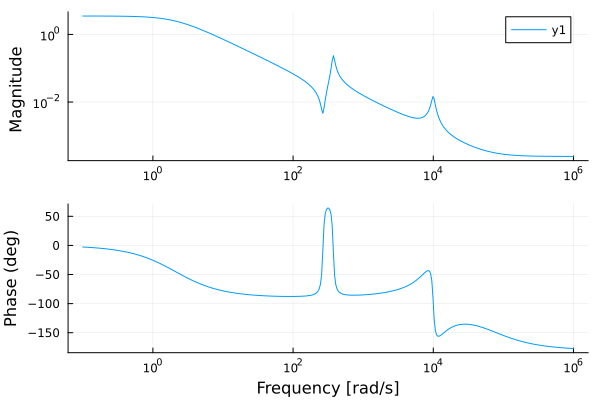

In [266]:
s = tf("s")
G = parse_tf_from_file("tf_txt/Gf.txt")

bodeplot(G)

In [267]:
function pt2(w0,d)
    s = tf("s")
    return w0^2/(s^2 + 2*d*w0*s + w0^2)
end

pt2 (generic function with 1 method)

# Uncertainty

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
 10.0s^3 + 2530.0000000000027s^2 + 632500.0000000006s + 1.8750000000000014e6
-----------------------------------------------------------------------------
1.0s^3 + 30040.000000000025s^2 + 1.2625000000000058e6s + 1.8750000000000007e9

Continuous-time transfer function model

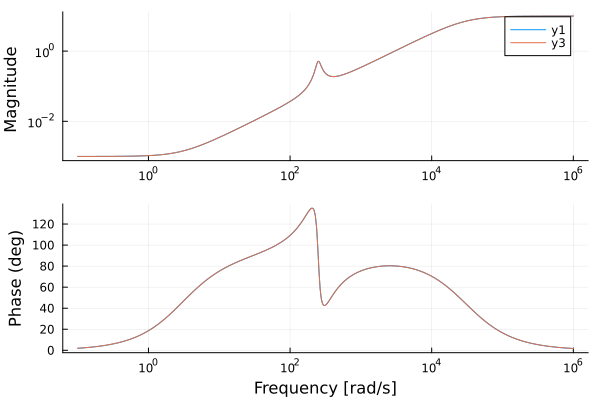

In [268]:

W1 = 0.1
W2 = pt2(250,0.1)/pt2(250,0.8)
W3 = (s/3000 + 1)^2/(s/(5*1e5) + 1)^2
W_delta = W1*W2*W3


ROB_SCALE = 1 # Increase for more robustness
W_delta = makeweight(0.01, 2000, 40) |> tf
#W_delta = W_delta* pt2(280,0.2)/(pt2(280,2)) * ROB_SCALE
W_delta = W_delta* pt2(270,0.1)/(pt2(270,0.8)) * ROB_SCALE
W_delta0 = parse_tf_from_file("tf_txt/W_delta.txt")

W_delta = ss(1)*1.09
W_delta = parse_tf_from_file("tf_txt/W_delta.txt")

#W_delta = ss(1.1)


print(W_delta)

bodeplot([W_delta0,W_delta])



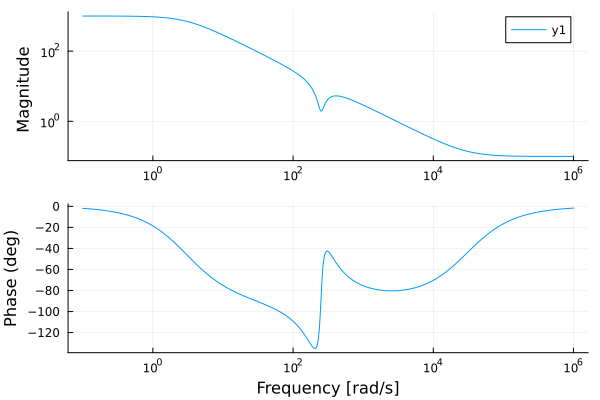

In [269]:
bodeplot(1/W_delta)

# Control limit

50265.48245743669

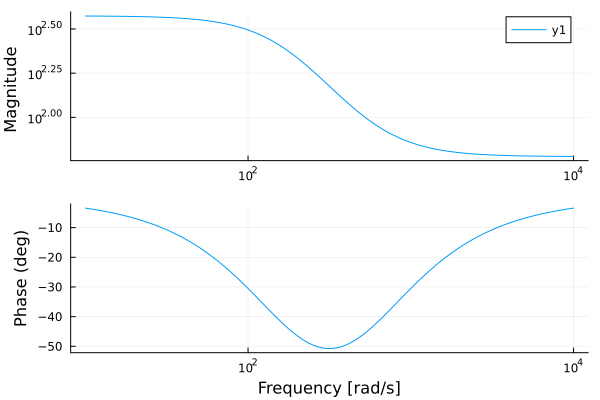

In [270]:


# Max Torque, and Nyquist freq as dynamic limit
w_nyq = 2*pi/(125*1e-6)
print(w_nyq)
max_T = 50


WU = pt2(200,1)/pt2(500,1) * 500 # best so far



#WU = pt2(150,1)/pt2(300,1) * 300 

inf_gain = evalfr(WU, im*1e6)
inf_gain = abs(inf_gain[1,1])

#WU = WU/abs(inf_gain) * 45
WU = WU/abs(inf_gain) * 60

#WU =  220.0*ss(1.0)
#WU = 120*ss(1.0)

bodeplot(WU)


In [271]:
WU = 1/WU

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
                     250000.0s^2 + 1.0e8s + 1.0e10
-----------------------------------------------------------------------
1.4999996850000788e7s^2 + 1.4999996850000786e10s + 3.749999212500197e12

Continuous-time transfer function model

0.44
528.0
2752.75
3300.0

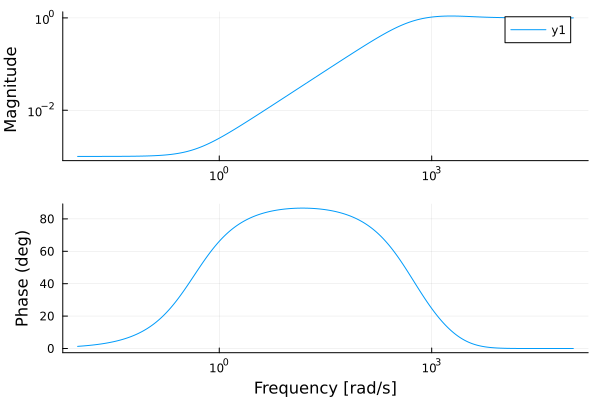

In [272]:
# Desired closed loop bw rad/s
omega_cl = 80*6.6
omega_max = 500*6.6


S_max = 1.2
S_inf = 1.001
S_L = 1e-3


omega_0 = omega_cl/S_max * S_L

omega_r = S_inf/S_max * omega_max

print(omega_0)
print('\n')
print(omega_cl)
print('\n')
print(omega_r)
print('\n')
print(omega_max)


WS = (s/omega_0 + 1)/(s/omega_cl + 1) * (s/omega_max + 1)/(s/omega_r + 1)*S_L #* pt2(250,0.3)/pt2(250,1.0)

WS = 1/WS

bodeplot(1/WS)

In [273]:

WT = W_delta

P = hinfpartition(G, WS, WU, WT)
hinfassumptions(P)



All assumtions are satisfied!


true

1.1369575878098206

┌ Warning: Numerical problems encountered, returned γ is adjusted to the γ achieved by the computed controller (γ - γactual = -0.038773912718241155). Try solving the problem in higher precision by calling hinfsynthesize(...; ftype=BigFloat)
└ @ RobustAndOptimalControl C:\Users\Elias\.julia\packages\RobustAndOptimalControl\Qj5nj\src\hinfinity_design.jl:203


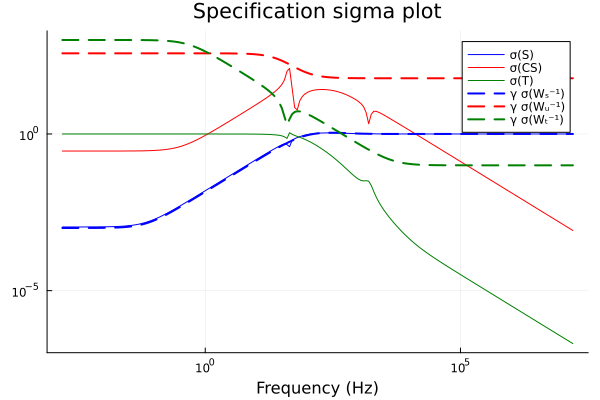

In [274]:
K, y = hinfsynthesize(P, γrel=1.05)
K = minreal(K)
print(y)

Pcl, S, KS, T = hinfsignals(P, G, K)

specificationplot([S,K*S,T], [WS,WU,WT],wint=(-2,8))

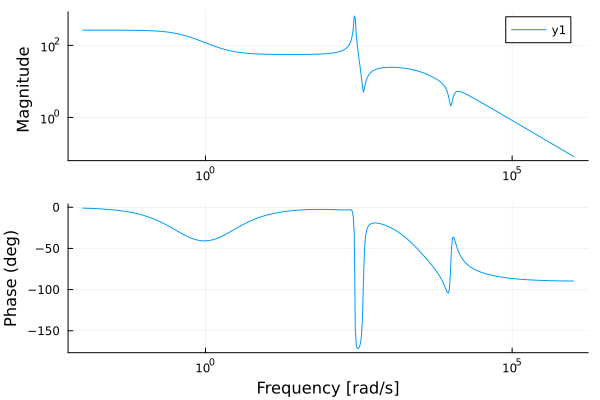

In [275]:
bodeplot(K)

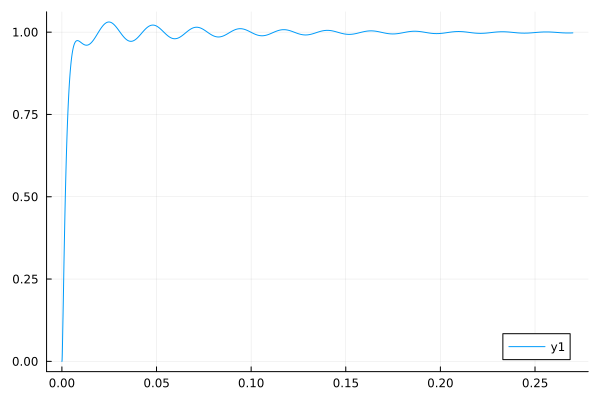

In [276]:
Pcl = G*K/(1 + G*K)

Pcl = minreal(Pcl)
y, t = step(Pcl);
plot(t, y')

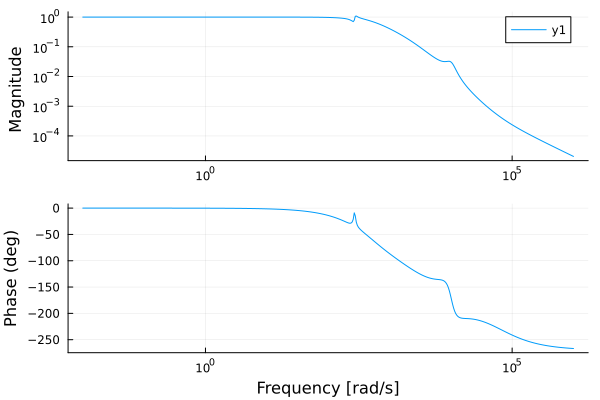

In [277]:



bodeplot(Pcl)

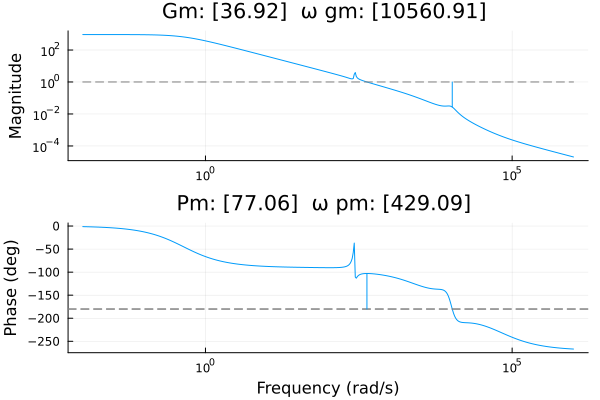

In [278]:
L = minreal(G*K)
marginplot(L)

In [279]:
K = tf(K)

num = K.matrix[1,1].num.coeffs
den = K.matrix[1,1].den.coeffs

fpath = "tf_txt/C_hinf.txt"
open(fpath, "w") do file
    write(file, string(num))
    write(file, "\n")
    write(file, string(den))
end

K

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
    83018.12255135141s^11 + 3.117134804454417e9s^10 + 2.817445719629681e13s^9 + 3.364487556246613e17s^8 + 1.7079139624217703e21s^7 + 1.6310528355261912e24s^6 + 7.905460640646701e26s^5 + 3.345492591142987e29s^4 + 9.558135466301233e31s^3 + 1.535115082885893e34s^2 + 3.0109650984646977e36s + 6.249002882613922e36
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^12 + 43678.99826139359s^11 + 5.59011372519054e8s^10 + 6.06598626609473e12s^9 + 3.4975220969507284e16s^8 + 8.153994104907085e19s^7 + 6.255299197136576e22s^6 + 2.495611256083042e25s^5 + 8.379566693087359e27s^4 + 2.126619073334841e30s^3 + 2.9068861725014367e32s^2 + 5.377181901318485e34s + 2.36035038896